<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from array import array
import pickle
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def pickle_all(key,value):
         pickle_out = open(key+"_lstm.pkl", "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [26]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


In [27]:
df_date=pd.DataFrame()
df_date["Time"] = pd.date_range(start='2020-02-02 18:00:00', periods=400, freq='H')

In [28]:
for col in df.columns[1:]:
  df_date[col] = [np.nan for i in range(len(df_date["Time"]))]

In [29]:
#df=pd.concat([df, df_date],axis=0)
#df=df.reset_index(drop=True)

In [82]:
df

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902
...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.165436,0.155614,16.767343,0.092335,8.327532,0.010000
396,2020-02-02 15:00:00,0.203813,0.173919,16.581073,0.103380,8.316859,0.011656
397,2020-02-02 16:00:00,2.264839,1.148385,20.762806,0.550969,4.669187,0.117801
398,2020-02-02 17:00:00,1.853924,0.940645,26.438105,0.378305,3.659111,0.103263


In [125]:
def lstm_save(df,col,date,time_step,layer_num):
    print(f"{col}"+50*"*")
    df1=df.reset_index()[col]
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler(feature_range=(0,1))
    df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
    #df1=np.array(df1).reshape(-1,1)
    training_size=len(df[df["Time"] < date][col].tolist())
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)
    training_size,test_size
    
    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    model=Sequential()
    model.add(LSTM(layer_num,return_sequences=True,input_shape=(time_step,1)))
    model.add(LSTM(layer_num,return_sequences=True))
    model.add(LSTM(layer_num))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    
    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=24,verbose=0)
    
    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    ##Transformback to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    ### Calculate RMSE performance metrics
    import math
    from sklearn.metrics import mean_squared_error
    Train_RMSE=math.sqrt(mean_squared_error(y_train,train_predict))
    ### Test Data RMSE
    Test_RMSE=math.sqrt(mean_squared_error(ytest,test_predict))
    print(f"Train RMSE: {Train_RMSE} /// Test RMSE {Test_RMSE} /// Time Step {time_step} /// Number of layer {layer_num}")
    ### Plotting 
    # shift train predictions for plotting
    import matplotlib.pyplot as plt
    look_back=time_step
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
    # plot baseline and predictions
    plt.title(col)
    plt.plot(scaler.inverse_transform(df1))
    
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
   
    return test_data

vibx**************************************************
Train RMSE: 0.6454926623337575 /// Test RMSE 0.6512912979039731 /// Time Step 3 /// Number of layer 100


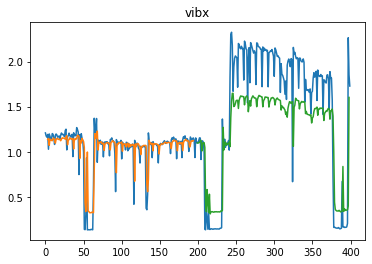

In [126]:
test_data=lstm_save(df,"vibx","2020-01-25 04:00:00",time_step=3,layer_num=100)

In [142]:
x_input=np.array(temp_input[1:])
            #print("{} hour input {}".format(i,x_input))
x_input=x_input.reshape(1,-1)
x_input = x_input.reshape((1, 3, 1))

ValueError: ignored

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
# demonstrate prediction for next  days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<day_to_pred*24):
        
    if(len(temp_input)>time_step):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            #print("{} hour input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            #print("{} hour output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
    else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
        

day_new=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,day_to_pred*24)
#plt.plot(day_new,scaler.inverse_transform(df1))
#plt.plot(day_pred,scaler.inverse_transform(lst_output))
df3=df1.tolist()
lst_output=scaler.inverse_transform(lst_output).tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
    
plt.plot(df3)

# vibx column Best Model

vibx**************************************************
Train RMSE: 0.6573561922381179 /// Test RMSE 0.6730403606311851 /// Time Step 3 /// Number of layer 100


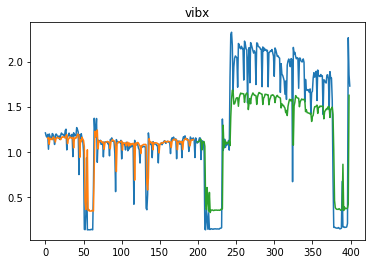

4


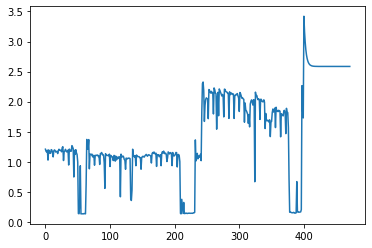

In [118]:
df3,lst_output=lstm_save(df,"vibx","2020-01-25 04:00:00",time_step=3,layer_num=100,day_to_pred=3)
      

# vibz column Best model

vibz**************************************************
Train RMSE: 0.6352259598144682 /// Test RMSE 0.6282542075774145 /// Time Step 10 /// Number of layer 100


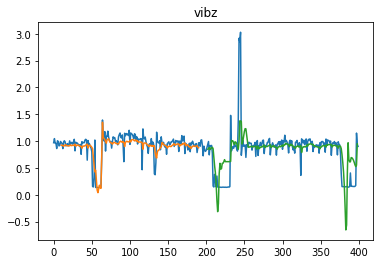

11


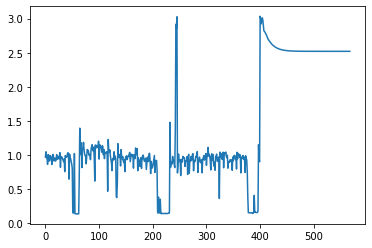

In [121]:
df3=lstm_save(df,"vibz","2020-01-25 00:00:00",time_step=10,layer_num=100, day_to_pred=7)

# temp column Best Model

temp**************************************************
Train RMSE: 26.139385082668493 /// Test RMSE 25.606389230360584 /// Time Step 20 /// Number of layer 100


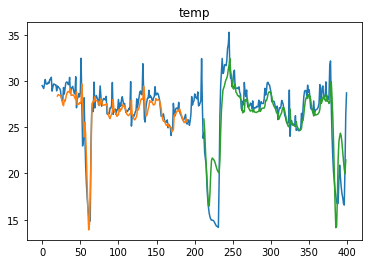

(26.139385082668493,
 25.606389230360584,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7fdd6e078690>)

In [ ]:
lstm_save(df,"temp","2020-01-25 00:00:00",time_step=20,layer_num=100,day_to_predict)

# zacc column Best model

zacc**************************************************
Train RMSE: 0.07645385574668671 /// Test RMSE 0.17483679572493208 /// Time Step 10 /// Number of layer 30


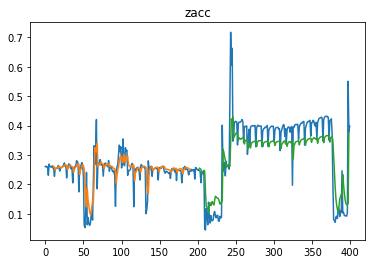

(0.07645385574668671,
 0.17483679572493208,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7fdd6b82f4d0>)

In [ ]:
lstm_save(df,"zacc","2020-01-25 00:00:00",time_step=10,layer_num=30)

# crest column best model

crest**************************************************
Train RMSE: 4.187552062436309 /// Test RMSE 4.261910368543533 /// Time Step 10 /// Number of layer 20


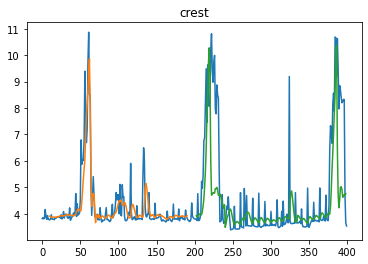

(4.187552062436309,
 4.261910368543533,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7fdd68fbb950>)

In [ ]:
lstm_save(df,"crest","2020-01-25 00:00:00",time_step=10,layer_num=20)

# zfreq column best model

zfreq**************************************************
Train RMSE: 0.27398151812382227 /// Test RMSE 0.44333955328226415 /// Time Step 3 /// Number of layer 30


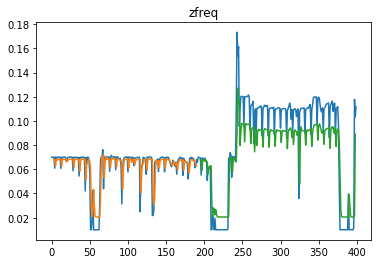

(0.27398151812382227,
 0.44333955328226415,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7fdd6653c7d0>)

In [ ]:
lstm_save(df,"zfreq","2020-01-25 00:00:00",time_step=3,layer_num=30)